# Visualisering av fremtidsrettet data
Denne filen analyserer fremtidig data fra A [YR sin API-tjeneste](https://api.met.no/weatherapi/locationforecast/2.0/documentation). Datasettet viser værprognoser for utvalgte steder for den kommende uken, og inkluderer blant annet informasjon om temperatur, vindhastighet og fuktighet. Nedenfor har gruppen gitt koordinater til noen steder, som kan brukes for å hente ut værdata. Det er mulighet for å legge til nye koordinater ved hjelp av metoden _add_location(place, lat, lon)_. Funksjonen _make_watherJSON(place)_ lager en JSON fil med hensyn på de gitte koordinater.

I store deler av den følgende oppgaven, blir det brukt pandas.Dataframe (df). Df gjør om dataene til et listeformat, noe som forenkler analyseaspekteret sammenlignet med JSONs dictionary-format. Koden blir mer lesbar og er ofte kortere enn kode som er skrevet med JSON's dictonary-format. Dataframes blir derfor brukt til å gjennomføre analysene og generere de visualisere grafene.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm

In [2]:
locations = {
    #"place": (lat, lon)
    "Stryn": (61.903901, 6.706899),
    "Longyearbyen": (78.225920, 15.625622),
    "Paris": (48.854289, 2.342042),
    "London": (51.501814, -0.140605),
    "Cape Town": (-33.922348, 18.424031),
    "New York": (40.710676, -74.006219),
    "Tokyo" : (35.681599, 139.767185)
}

def add_location(place, lat, lon):
    
    if place not in locations.keys():
        locations[place] = (lat, lon)
        print(f"{place} ble lagt til med koordinater ({lat}, {lon})")

    else:
        print(f"{place} finnes allerede i dictionary.")

    return locations

#print(locations)

In [3]:
def make_weatherJSON(place):

    if place not in locations.keys():
        raise Exception(f"{place} ikke funnet i {locations.keys()}")

    url = f"https://api.met.no/weatherapi/locationforecast/2.0/compact?lat={locations[place][0]}&lon={locations[place][1]}"
    headers = {'User-Agent': 'my-weather-app/1.0'}  #nødvendig for Yr API
    response = requests.get(url, headers=headers)
    
    
    if response.status_code != 200:
        raise Exception(f"API call failed with status code {response.status_code}")
    
    data = response.json()

    if not data:
        raise Exception("Ingen data i JSON-objekt")
    
    return data

#make_weatherJSON("Løngyearbyen") #(feilmenlding)
#make_weatherJSON("Longyearbyen")


### Oppgave 4 - Dataanalyse
Listen _value_weather_entry_ er viser hvilke instaser som er gyldige for de kommende metodene. Metoden _get_weatherDataframe(place)_ gjør om dataen fra _make_weatherJSON(place)_ til Dataframes. Metoden baserer seg på en _value_weather_entry_-listen, som gjenspeiler hvilke verdier som APIen måler. I tillegg gjøres NaN-verdier om til 0 for å forenkle senere kalkulasjoner.

Metoden _get_statistics(place, weather_entry)_ beregner gjennomsnitt, median og standardavvik på en gitt verdi (weather_entry) fra value_weather_entry-listen. De statistiske målene er viktig siden de gir en indikasjon på hvordan dataen fordeler seg og med hvilke variasjoner de har. Når målingene er utregnet blir dataen plottet som et histogram (med normalfordeling) for å visualiseres. 

I følge SNL er [korrelasjon](https://snl.no/korrelasjon) "et statistisk mål på hvor mye to målbare størrelser henger sammen med hverandre." Metoden _correlation(place, weather_entry1, weather_entry2)_ regner ut korrelasjonen mellom to gitte instanser fra value_weather_entry-listen, for å se om det er noe sammenheng mellom dataen. Jo nærmere 1 eller -1, jo større korrelasjon er det mellom dataen. Det blir igjen plottet i en graf for å visualisere resultatene.



MANGLER KODE TIL
"Hvordan planlegger du å håndtere eventuelle skjevheter i dataene under analysen, og hvilke metoder vil du bruke for å sikre at analysen er pålitelig?"

In [4]:
#listen gir oversikt over hvilke instanser (weather_entry) som er gydlige for JSON-filen
value_weather_entry = ["Temperatur (C°)", "Fuktighet (%)" ,"Vindhastighet (m/s)", "Nedbør (mm)"]

In [5]:
#lager Dataframes av dataen
def get_weatherDataframe(place):
    data = make_weatherJSON(place)

    timeseries = data["properties"]["timeseries"]

    weather_lst = [
        {
            "Tid": entry["time"],
            value_weather_entry[0]: entry["data"]["instant"]["details"].get("air_temperature"),
            value_weather_entry[1]: entry["data"]["instant"]["details"].get("relative_humidity"),
            value_weather_entry[2]: entry["data"]["instant"]["details"].get("wind_speed"), 
            value_weather_entry[3]: entry["data"]["instant"]["details"].get("precipitation_amount")
            
        }
        for entry in timeseries
    ]

    df = pd.DataFrame(weather_lst)
    df["Tid"] = pd.to_datetime(df["Tid"])
    df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0
    return df

get_weatherDataframe("New York")

C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


,Tid,Temperatur (C°),Fuktighet (%),Vindhastighet (m/s),Nedbør (mm)
0,2025-04-14 07:00:00+00:00,6.7,71.9,3.3,0
1,2025-04-14 08:00:00+00:00,6.3,72.7,3.3,0
2,2025-04-14 09:00:00+00:00,6.1,72.2,3.2,0
3,2025-04-14 10:00:00+00:00,5.7,73.2,2.9,0
4,2025-04-14 11:00:00+00:00,5.9,72.9,2.5,0
...,...,...,...,...,...
82,2025-04-22 12:00:00+00:00,16.5,85.6,3.8,0
83,2025-04-22 18:00:00+00:00,24.4,61.5,4.6,0
84,2025-04-23 00:00:00+00:00,20.0,87.3,3.5,0
85,2025-04-23 06:00:00+00:00,17.3,95.8,2.1,0


C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


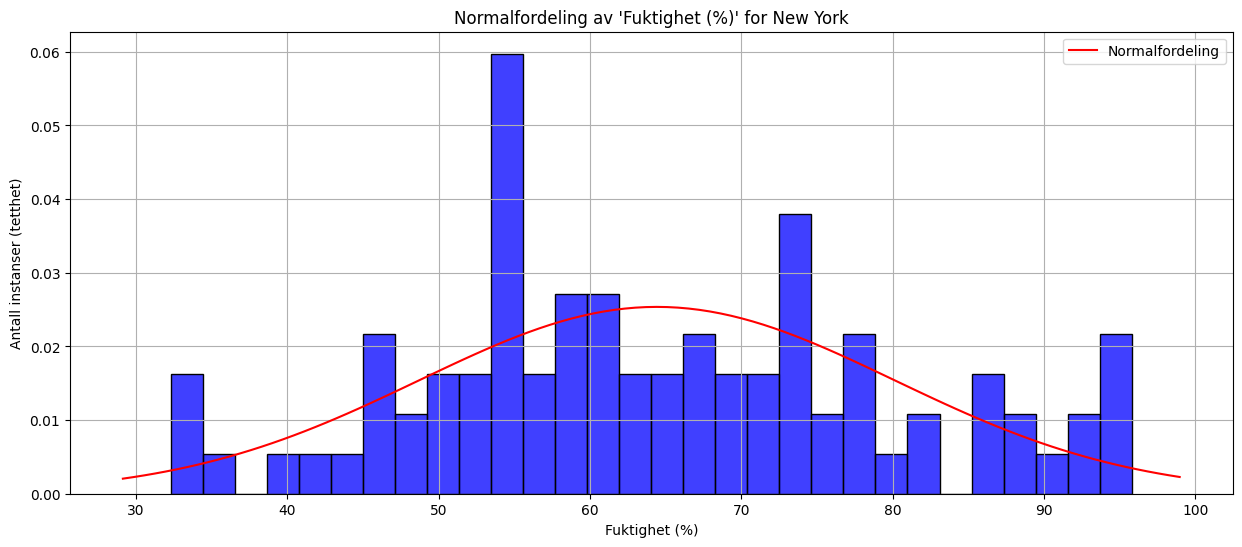

'Gjennomsnitt: 64.422, Median: 63.0, Standardavvik: 15.729'

In [6]:
def get_statistics(place, weather_entry):
    df = pd.DataFrame(get_weatherDataframe(place))

    #sjekker om entry er i datasettet
    if weather_entry not in df.columns:
        raise ValueError(f"{weather_entry} finnes ikke i datasettet.")


    #beregner ønskede verdier
    average = df[weather_entry].mean()  
    median = df[weather_entry].median()  
    std = df[weather_entry].std() 
    string = f"Gjennomsnitt: {round(average, 3)}, Median: {round(median, 3)}, Standardavvik: {round(std, 3)}"


    #plotter histogram og normalfordeling
    plt.figure(figsize=(15,6))
    sns.histplot(df[weather_entry], color='b', stat="density", bins=30)
    xmin, xmax = plt.xlim()  
    x = np.linspace(xmin, xmax, 100) #baserer diagrammet på største og minste verdi i datasettet
    p = norm.pdf(x, average, std) 
    plt.plot(x, p, 'r', label="Normalfordeling")
    plt.xlabel(weather_entry)
    plt.ylabel("Antall instanser (tetthet)")
    plt.title(f"Normalfordeling av '{weather_entry}' for {place}")
    plt.grid()
    plt.legend()
    plt.show() 

    return string


#get_statistics(locations["New York"][0], "temp") #(feilmelding)
get_statistics("New York", value_weather_entry[1])


C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


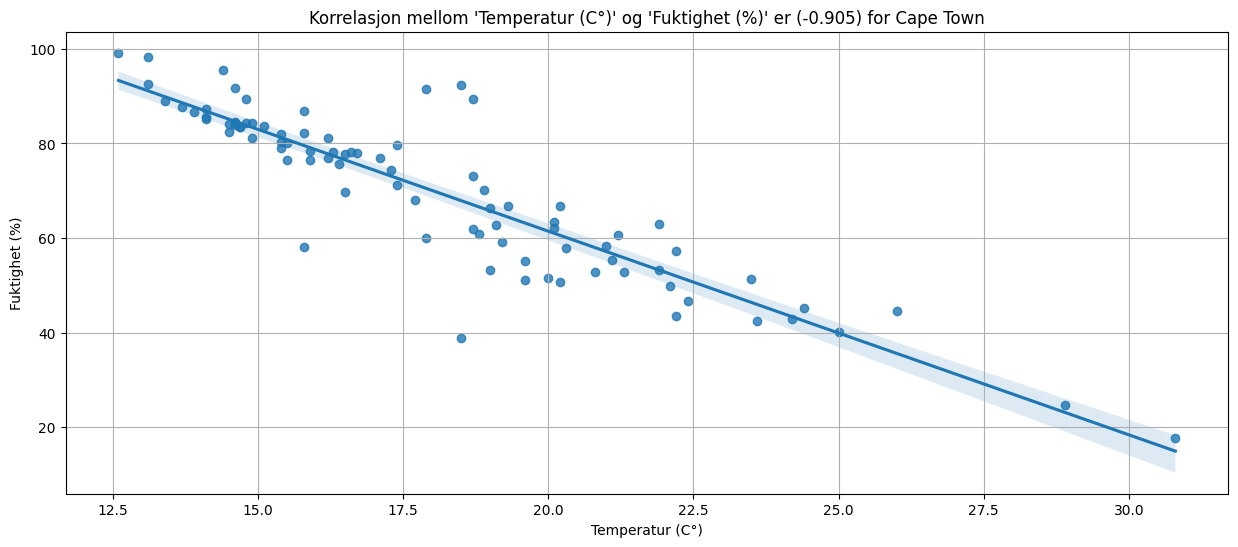

Korrelasjon mellom 'Temperatur (C°)' og 'Fuktighet (%)' er (-0.905) for Cape Town


In [7]:
def correlation(place, weather_entry1, weather_entry2):
    df = get_weatherDataframe(place)


    #sjekker om entry er en instans i filen
    if weather_entry1 not in df.columns or weather_entry2 not in df.columns:
        raise Exception("Instans(ene) finnes ikke i datasettet")
    

    #regner ut korrelasjon
    correlation = df[weather_entry1].corr(df[weather_entry2])
    string = f"Korrelasjon mellom '{weather_entry1}' og '{weather_entry2}' er ({round(correlation,3)}) for {place}"


    plt.figure(figsize=(15,6))
    sns.regplot(x=df[weather_entry1], y=df[weather_entry2])
    plt.xlabel(weather_entry1)
    plt.ylabel(weather_entry2)
    plt.title(string)
    plt.grid()
    plt.show()

    return string


print(correlation("Cape Town", value_weather_entry[0], value_weather_entry[1]))


### Oppgave 5 - Visualisering
Metoden _plot_weather(place, weather_entry)_ plotter lineære grafer basert på plass og værparameter. Her er det mulighet for å se hvordan temperaturer, fuktighet eller vindhastighet utvikler seg over tid i for eksempel London (basert på byene fra locations-dictoneryen). I tillegg viser metoden _rain_pieplot(place)_ oversikt over hvor mye det regner i løpe av en dag i prosent for en gitt plass. De to metodene beskriver dataen på en visuell måte.

C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


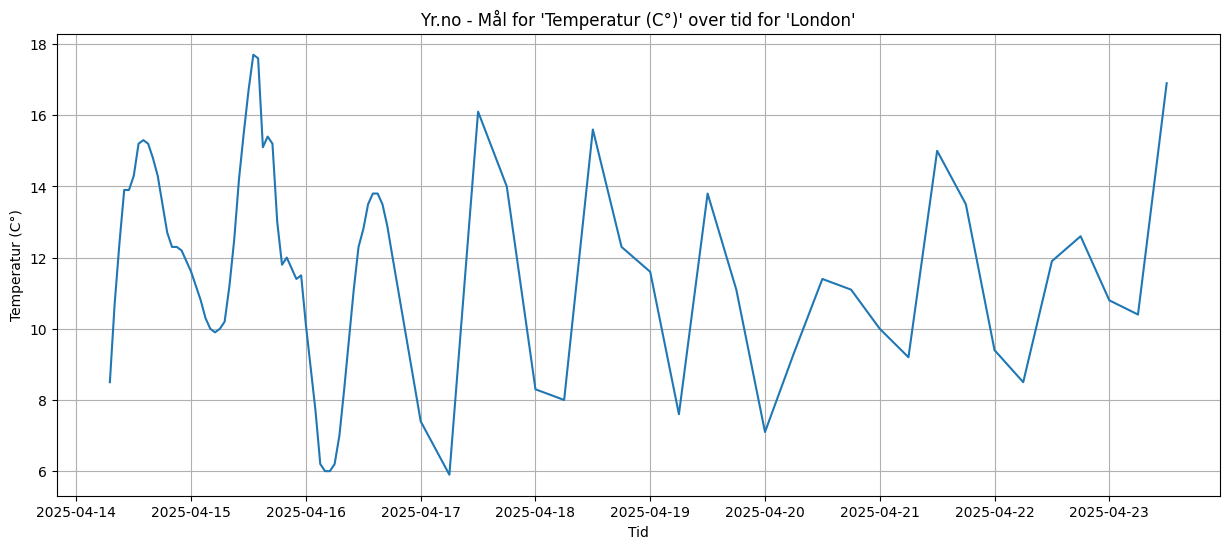

C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


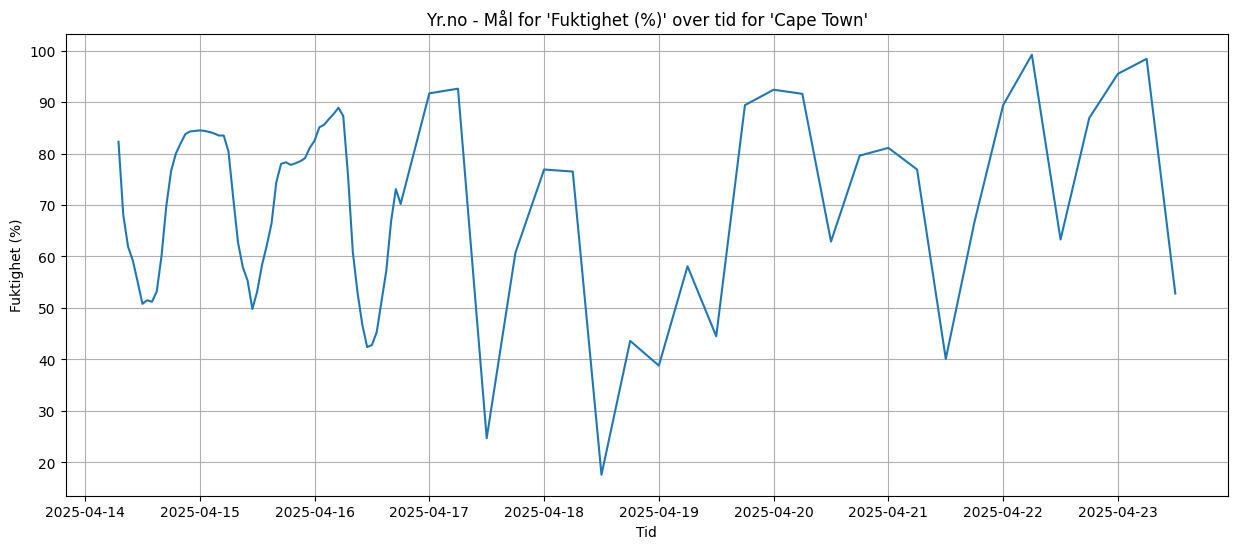

C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


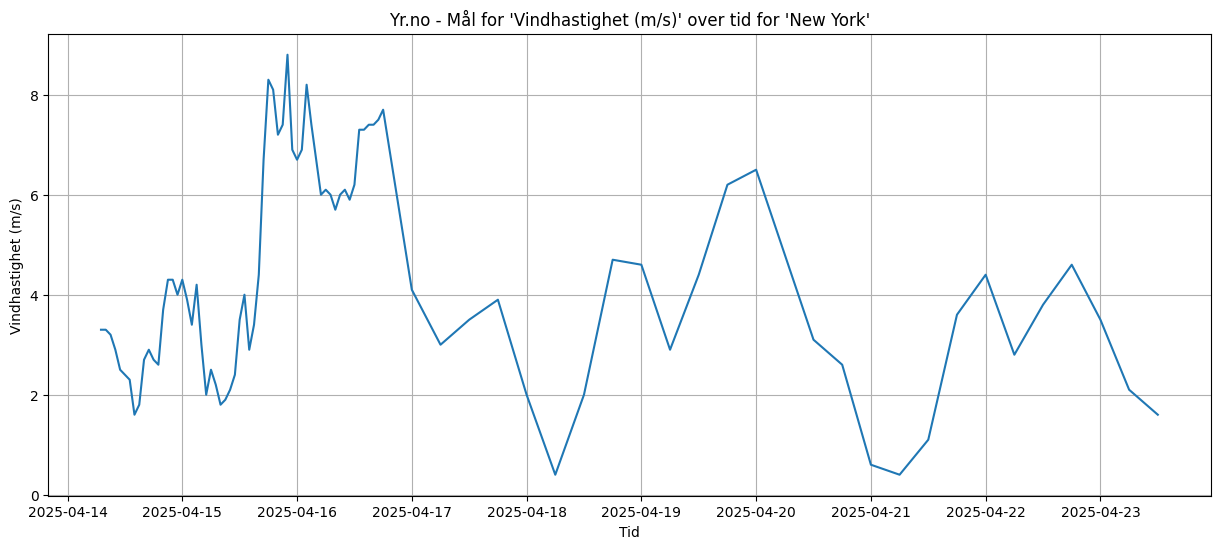

C:\Users\leneg\AppData\Local\Temp\ipykernel_14548\3723725503.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  #erstatter NaN-verdier med 0


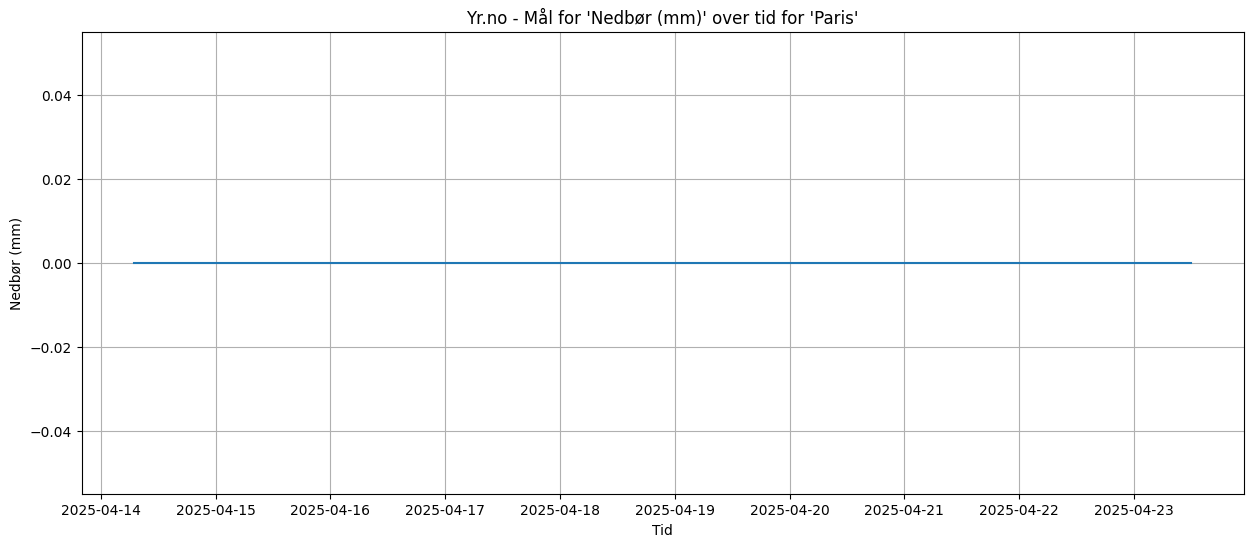

In [14]:
#lager grafer som beskriver været over tid for en gitt plass
def plot_weather(place, weather_entry):
    df = get_weatherDataframe(place)

    #sjekker om entry er en instans i filen
    if weather_entry not in df.columns:
        raise Exception("Instans(ene) finnes ikke i datasettet")

    plt.figure(figsize=(15, 6))   
    sns.lineplot(data=df, x="Tid", y=weather_entry) 
    plt.xlabel("Tid")
    plt.ylabel(weather_entry)
    plt.title(f"Yr.no - Mål for '{weather_entry}' over tid for '{place}'")
    plt.grid()
    plt.show()

#print(locations.keys())
plot_weather("London", value_weather_entry[0])
plot_weather("Cape Town", value_weather_entry[1])
plot_weather("New York", value_weather_entry[2])
plot_weather("Paris", value_weather_entry[3])